In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

curr_dir = os.getcwd()

## LLMs

Checking gemini_response against labels...
True Positives: 46, True Negatives: 41, False Positives: 9, False Negatives: 4
Accuracy: 0.87


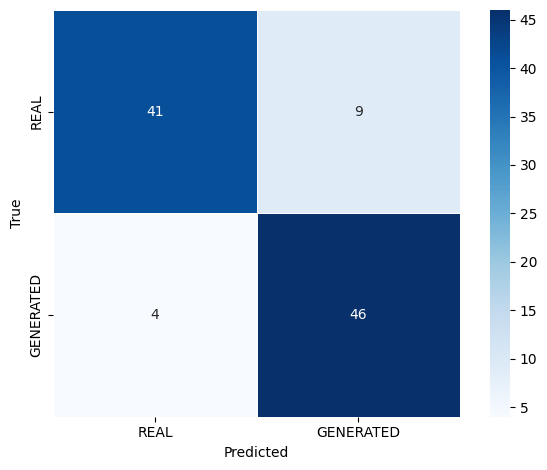

Checking claude_response against labels...
True Positives: 39, True Negatives: 46, False Positives: 4, False Negatives: 11
Accuracy: 0.85


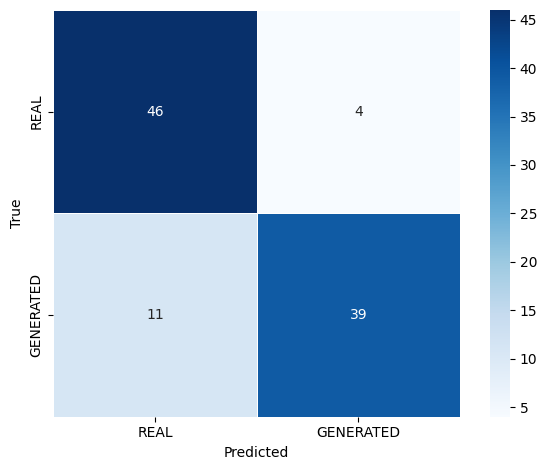

Checking llama_response against labels...
True Positives: 20, True Negatives: 46, False Positives: 4, False Negatives: 30
Accuracy: 0.66


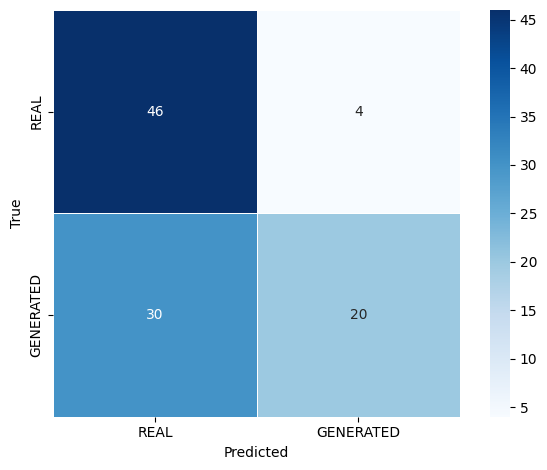

Checking chatgpt_response against labels...
True Positives: 19, True Negatives: 33, False Positives: 17, False Negatives: 31
Accuracy: 0.52


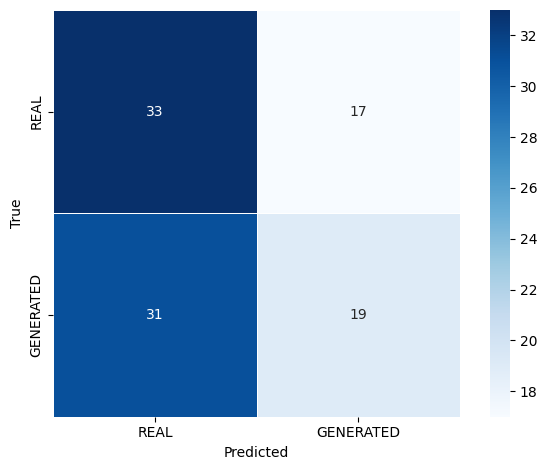

In [36]:
labels_list = os.path.join(curr_dir, 'samples_for_llms_labels.txt')

for llm_resp in os.listdir(curr_dir):
    tp, tn, fp, fn = 0, 0, 0, 0
    if not llm_resp.endswith('.txt') or llm_resp in ['samples_for_llms_labels.txt', 'samples_for_llms.txt']:
        continue

    print(f"Checking {llm_resp.split('.')[0]} against labels...")
    with open(os.path.join(curr_dir, llm_resp), 'r', encoding='utf-8') as f:
        llm_resp_content = f.read()

    with open(labels_list, 'r', encoding='utf-8') as f:
        labels_content = f.read()

    llm_resp_content = [line for line in llm_resp_content.splitlines() if '#' not in line]
    labels_content = labels_content.splitlines()
    for pred_lbl, true_lbl in zip(llm_resp_content, labels_content):
        pred_lbl = pred_lbl.strip()
        true_lbl = true_lbl.split('.')[1].strip()

        if true_lbl == 'GENERATED':
            if pred_lbl == 'GENERATED':
                tp += 1
            else:
                fn += 1
        elif true_lbl == 'REAL':
            if pred_lbl == 'REAL':
                tn += 1
            else: 
                fp += 1

    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
    accuracy = (tp + tn) / 100
    print(f"Accuracy: {accuracy:.2f}")

    cm = np.array([
        [tn, fp],
        [fn, tp]
    ])
    labels = ['REAL', 'GENERATED']

    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                cbar=True,
                linewidths=0.5,
                square=True)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(os.path.join(curr_dir, f'confusion_matrix_{llm_resp.split(".")[0]}.svg'))
    plt.show()


    print('=' * 50)

## Survey

Checking All responses against labels...
AVERAGE SCORES: True Positives: 21, True Negatives: 29, False Positives: 21, False Negatives: 29
Accuracy: 0.50


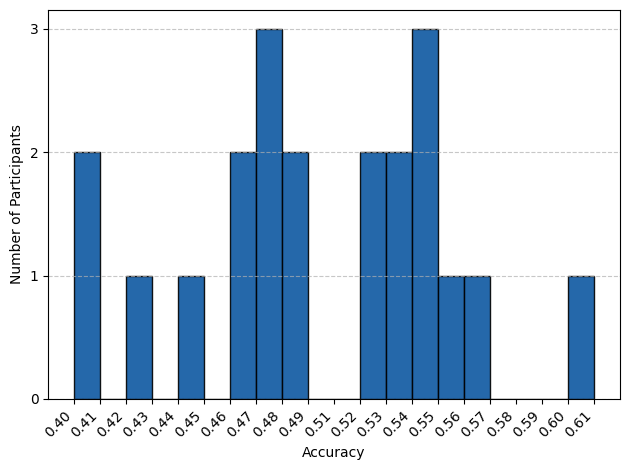

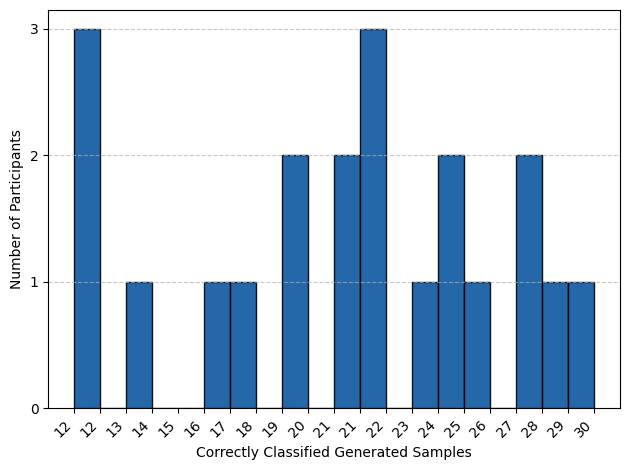

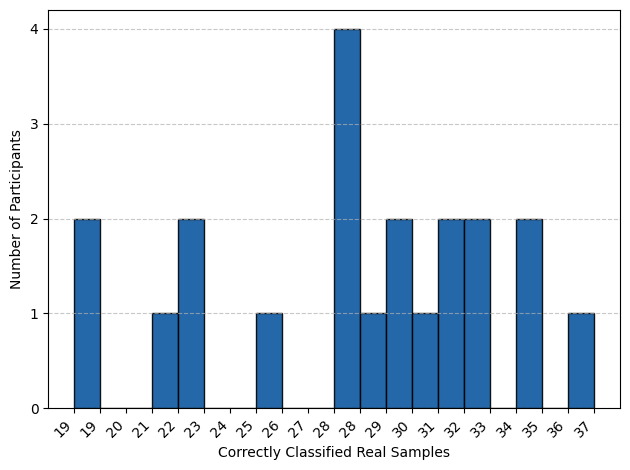

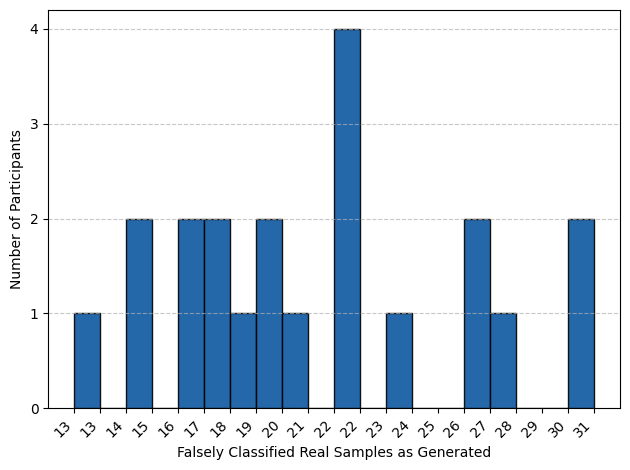

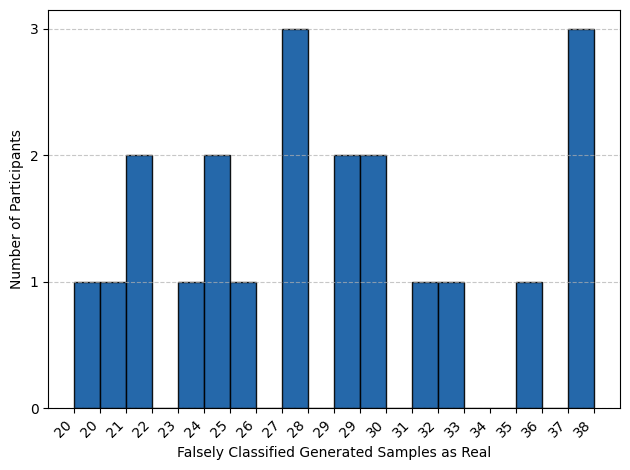

Checking Student responses against labels...
AVERAGE SCORES: True Positives: 21, True Negatives: 28, False Positives: 22, False Negatives: 29
Accuracy: 0.50


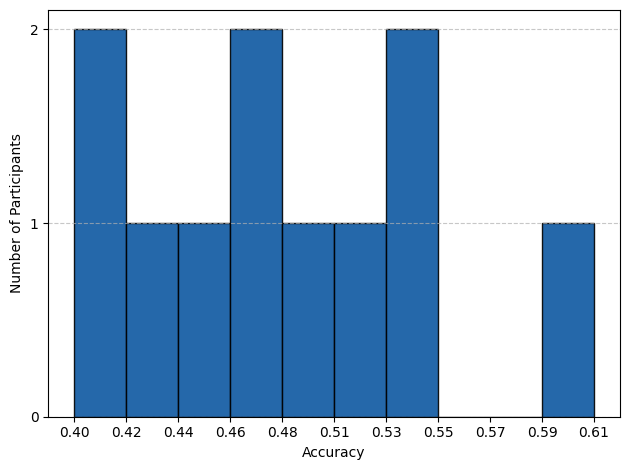

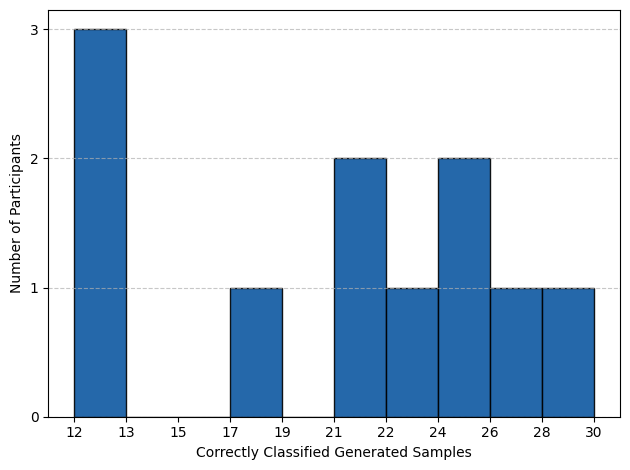

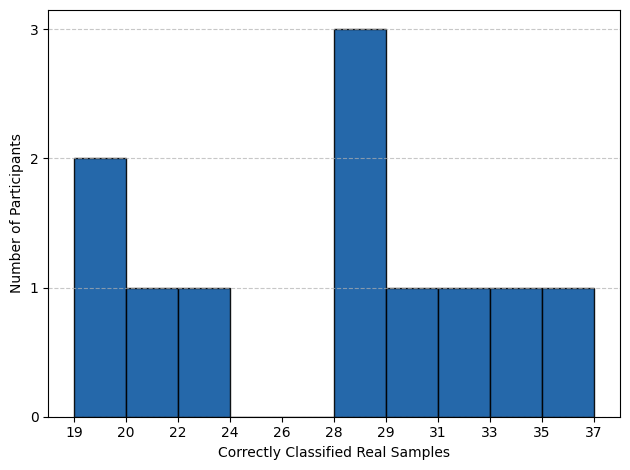

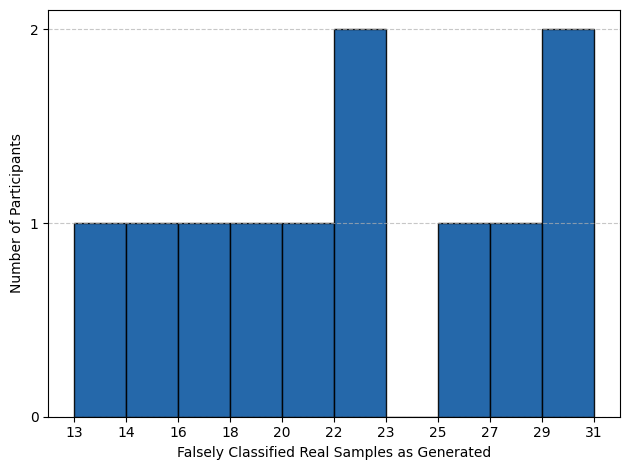

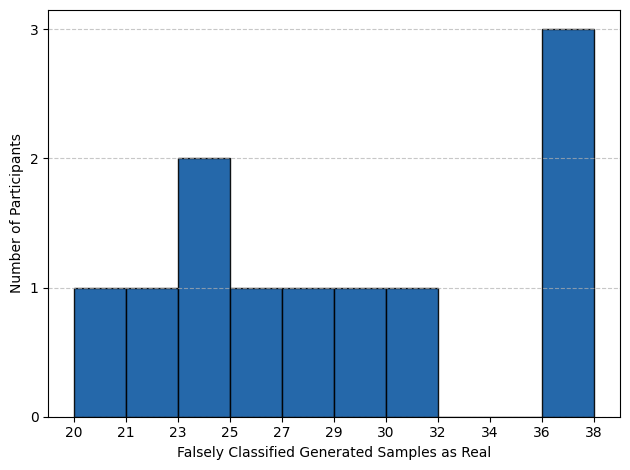

Checking Analyst responses against labels...
AVERAGE SCORES: True Positives: 22, True Negatives: 30, False Positives: 20, False Negatives: 28
Accuracy: 0.50


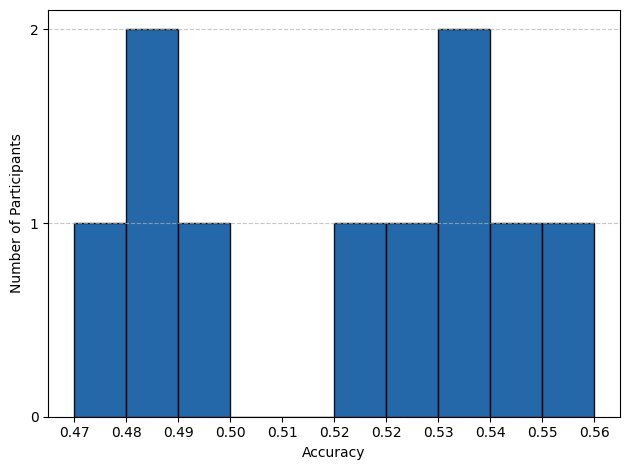

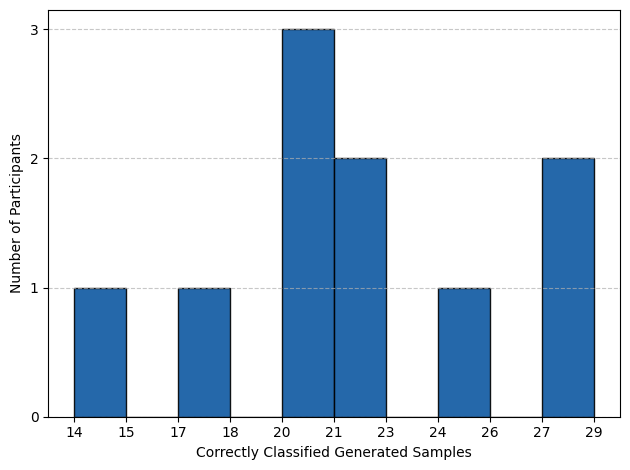

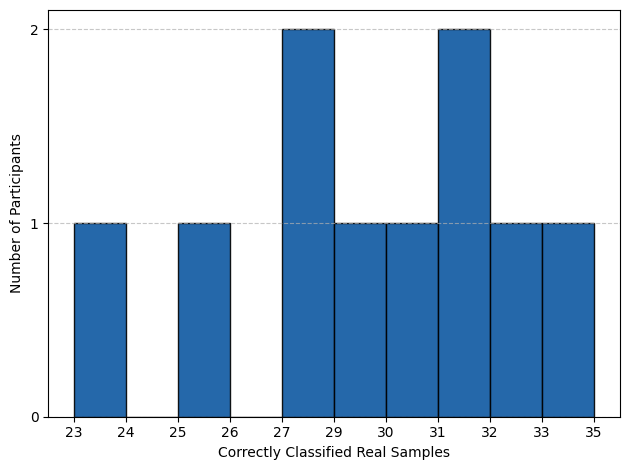

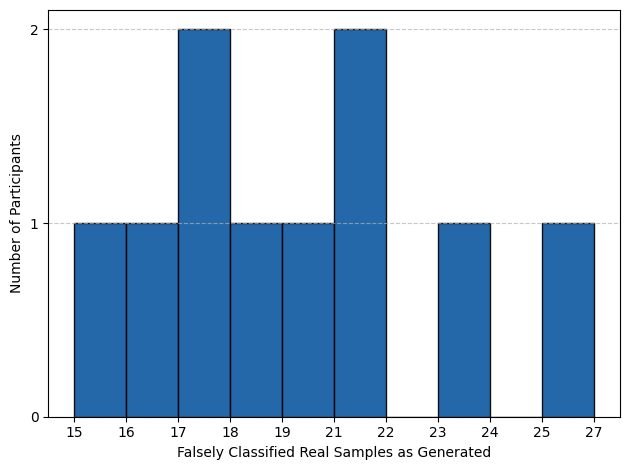

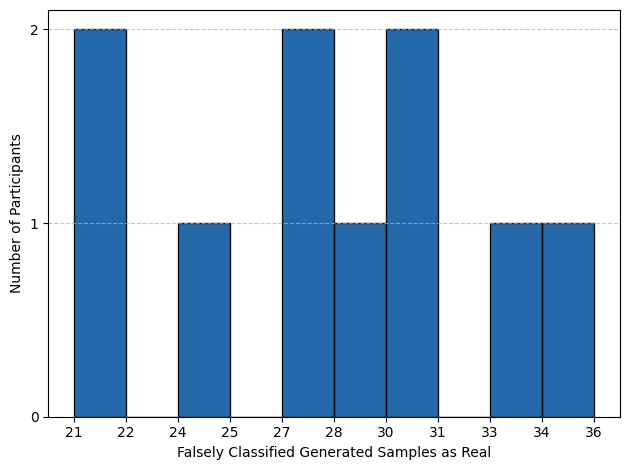

In [56]:
from matplotlib.ticker import MaxNLocator, FixedLocator, FormatStrFormatter

survey = pd.read_csv(os.path.join(curr_dir, 'survey_scores.csv'), comment='#')

all_scores, student_scores, analyst_scores = {'accuracy': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}, {'accuracy': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}, {'accuracy': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}
for i, row in survey.iterrows():
    all_scores['accuracy'].append(row['Accuracy'] / 100)
    all_scores['tp'].append(row['True Positives'])
    all_scores['tn'].append(row['True Negatives'])
    all_scores['fp'].append(row['False Positives'])
    all_scores['fn'].append(row['False Negatives'])
    if 'student' in row['Experience']:
        student_scores['accuracy'].append(row['Accuracy'] / 100)
        student_scores['tp'].append(row['True Positives'])
        student_scores['tn'].append(row['True Negatives'])
        student_scores['fp'].append(row['False Positives'])
        student_scores['fn'].append(row['False Negatives'])
    elif 'analyst' in row['Experience']:
        analyst_scores['accuracy'].append(row['Accuracy'] / 100)
        analyst_scores['tp'].append(row['True Positives'])
        analyst_scores['tn'].append(row['True Negatives'])
        analyst_scores['fp'].append(row['False Positives'])
        analyst_scores['fn'].append(row['False Negatives'])

for scores, name in zip([all_scores, student_scores, analyst_scores], ['All', 'Student', 'Analyst']):
    tp, tn, fp, fn = round(np.mean(scores['tp'])), round(np.mean(scores['tn'])), round(np.mean(scores['fp'])), round(np.mean(scores['fn']))  # Ensure integer values

    print(f"Checking {name} responses against labels...")
    print(f"AVERAGE SCORES: True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
    # accuracy = (tp + tn) / 100  # as we round the values it's better to calculate accuracy based on earlier values
    print(f"Accuracy: {np.mean(all_scores['accuracy']):.2f}")

    cm = np.array([
        [tn, fp],
        [fn, tp]
    ])
    labels = ['REAL', 'GENERATED']

    # sns.heatmap(cm,
    #             annot=True,
    #             fmt='d',
    #             cmap='Blues',
    #             xticklabels=labels,
    #             yticklabels=labels,
    #             cbar=True,
    #             linewidths=0.5,
    #             square=True)

    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.tight_layout()
    # plt.savefig(os.path.join(curr_dir, f'confusion_matrix_{name}.svg'))
    # plt.show()

    for metric_text, metric_name in zip(['Accuracy',
                              'Correctly Classified Generated Samples', 
                              'Correctly Classified Real Samples', 
                              'Falsely Classified Real Samples as Generated', 
                              'Falsely Classified Generated Samples as Real'], 
                             ['accuracy', 'tp', 'tn', 'fp', 'fn']):

        bin_num = 10 if len(scores[metric_name]) < 12 else 20
        counts, bin_edges, _  = plt.hist(scores[metric_name], bins=bin_num, color=plt.cm.Blues(0.85), alpha=0.9, edgecolor='black')
        plt.xlabel(metric_text)
        plt.ylabel('Number of Participants')
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

        ax = plt.gca()
        ax.xaxis.set_major_locator(FixedLocator(bin_edges))
        if metric_name == 'accuracy':
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        if bin_num > 10:
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(curr_dir, f'histogram_{metric_name}_{name}.svg'))
        plt.show()

    print('=' * 50)